# Figure S4EF (Simulation to show that the stimulus autocorrelation alone does not account for the BTA timescales)
In our 'reverse correlation' experiments, we do not divide our bout-triggered averages by stimulus autocorrleation matrices ("whitening").

This is because this division makes everything super noisy, given the amount of data we have.

The worry then is that the time constants we are observing just reflect the stimulus autocorrelation, rather than the genuine memory process.

To exclude this possibility, we show that memory-less processes only produce much shorter timescales compared to what we observed experimentally.

In [6]:
import numpy as np
from matplotlib import pyplot as plt
from homr_util import *
from tqdm import tqdm

In [2]:
# Tweaking matplotlib 
set_rcParams()

## Simulation
### Parameters

In [4]:
sim_freq = 60 # Simulation rate in Hz
sim_dur  = 60 * 60 # Duration in s
n_repeat = 100 # repeat the simulation this many times

switch_freq = 0.5 # Stimulus direction switch frequency in Hz
bout_freq   = 1.0 # Simulated bout frequency in Hz

bta_length = 15 # BTA duration in s
t_vec = np.arange(-bta_length * sim_freq, 0) / sim_freq

In [8]:
# Generate timestamp 
t = np.arange(0, sim_dur, 1/sim_freq)

### Forward OMR simulation
- Bout is generated stochastically, only when stimulus direction is positive
- Do the same bout triggered averaging as in the real data analysis
- Note that I did not fix the random number generator seed when generating the published version of the figure, so the replication won't be exact

In [9]:
bta = []
for i in tqdm(range(n_repeat)):

    ## Stimulus Generation ##
    
    # generate uniform random sequence [0, 1]
    rand_seq = np.random.rand(sim_dur*sim_freq)
    # sample-wise switch rate is swicth_freq / sim_freq
    do_switch = rand_seq <= switch_freq/sim_freq
    # direction is binary (-1, +1)
    s = (np.cumsum(do_switch) % 2)*2 - 1

    ## Response generation ##
    # generate swim bout at the predetermined frequency, as long as stimulus is moving forward
    bout_spike = (s>0) * (np.random.rand(sim_dur*sim_freq)<=bout_freq/sim_freq)
    bout_ind = np.where(bout_spike)[0]
    bout_ind = bout_ind[bout_ind > bta_length*sim_freq] # remove too early bouts
    
    ## Reverse Correlation ##
    # dimensional expansion and 2d slicing
    ind_mat = np.arange(-sim_freq*bta_length, 0)[None, :] + bout_ind[:, None]
    s_mat = s[ind_mat]
    bta.append(np.mean(s_mat, axis=0))
    
bta = np.asarray(bta) 

100%|██████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 51.93it/s]


### Rotational OMR simulation
- Signed bouts are generated in the same direction as the ongoing stimulus
- Do the same analysis as in the data

In [10]:
rbta = []
for i in tqdm(range(n_repeat)):

    ## Stimulus Generation ##
    
    # generate uniform random sequence [0, 1]
    rand_seq = np.random.rand(sim_dur*sim_freq)
    # sample-wise switch rate is swicth_freq / sim_freq
    do_switch = rand_seq <= switch_freq/sim_freq
    # direction is binary (-1, +1)
    s = (np.cumsum(do_switch) % 2)*2 - 1

    ## Response generation ##
    # generate swim bout at the predetermined frequency, as long as stimulus is moving forward
    bout_spike = np.random.rand(sim_dur*sim_freq)<=bout_freq/sim_freq
    bout_ind = np.where(bout_spike)[0]
    bout_ind = bout_ind[bout_ind > bta_length*sim_freq] # remove too early bouts
    
    ## Reverse Correlation ##
    # dimensional expansion and 2d slicing
    ind_mat = np.arange(-sim_freq*bta_length, 0)[None, :] + bout_ind[:, None]
    s_mat = s[ind_mat] * s[bout_ind][:, None] # flip direction by response direction
    rbta.append(np.mean(s_mat, axis=0))
rbta = np.asarray(rbta) 

100%|██████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.32it/s]


### Fitting for both simulations

In [13]:
taus = np.zeros(n_repeat)
r_t0s = np.zeros(n_repeat)
r_taus = np.zeros(n_repeat)
for i in tqdm(range(n_repeat)):
    taus[i], _, _ = fit_exponential_direct(bta[i, :], bta_length, sim_freq)
    r_t0s[i], r_taus[i], _, _ = fit_logistic(rbta[i, :], bta_length, sim_freq, p0=(1,1,1))
tau_of_mean, _, _ = fit_exponential_direct(np.mean(bta, axis=0), bta_length, sim_freq)
r_t0_of_mean, r_tau_of_mean, y0_of_mean, _ = fit_logistic(np.mean(rbta, axis=0), bta_length, sim_freq, p0=(1,1,1))

100%|██████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 81.08it/s]


## Panels
### Fig. S4EF (Simulated memory-less BTA)

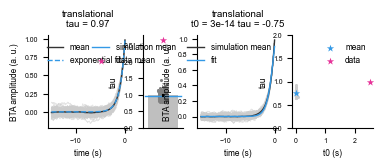

In [14]:
fig, ax = plt.subplots(1, 4, width_ratios=(2,1,2,2), figsize=(4.2,1.2))

# Forward BTA, individual iteration vs. average
ax[0].plot(t_vec, bta.T, color=(0.8,0.8,0.8), lw=0.5, alpha=0.5)
ax[0].plot(t_vec, np.mean(bta, axis=0), color=(0.2,0.2,0.2), label='mean')
ax[0].plot(t_vec, np.exp(-t_vec/tau_of_mean), linestyle='--', color=(0.2,0.6,0.9), label='exponential fit')

# Forward BTA, simulated exponential tau vs. data tau
scatter_bar([-taus], ax=ax[1], color=[(0.5,0.5,0.5)])
ax[1].plot((-0.5,0.5),(-tau_of_mean, -tau_of_mean),color=(0.2,0.6,0.9),label='simulation mean')
ax[1].scatter(0, 2.668, marker='*', s=30, color=(0.9,0.2,0.6), label='data mean')

# Rotational BTA, individual iteration vs. average
ax[2].plot(t_vec, rbta.T, color=(0.8,0.8,0.8), lw=0.5, alpha=0.5)
ax[2].plot(t_vec, np.mean(rbta, axis=0), color=(0.2,0.2,0.2), label='simulation mean')
ax[2].plot(t_vec, logistic(-t_vec, r_t0_of_mean, r_tau_of_mean, y0_of_mean), color=(0.2,0.6,0.9), label='fit')

# Rotational BTA, simulated vs. data logistic params
ax[3].scatter(r_t0s, r_taus, color=(0.8, 0.8, 0.8), s=5)
ax[3].scatter(r_t0_of_mean, r_tau_of_mean, marker='*', s=30, color=(0.2,0.6,0.9), label='mean')
ax[3].scatter(2.5, 0.98, marker='*', s=30, color=(0.9,0.2,0.6), label='data')
ax[3].set_ylim(0, 2)

# axis management
ax[0].set_title('translational\ntau = {:0.2}'.format(-tau_of_mean))
ax[2].set_title('translational\nt0 = {:0.2} tau = {:0.2}'.format(r_t0_of_mean, -r_tau_of_mean))

ax[0].set_xlabel('time (s)')
ax[1].set_xticks([])
ax[2].set_xlabel('time (s)')
ax[3].set_xlabel('t0 (s)')

ax[0].set_ylabel('BTA amplitude (a. u.)')
ax[1].set_ylabel('tau')
ax[2].set_ylabel('BTA amplitude (a. u.)')
ax[3].set_ylabel('tau')

for axx in ax:
    toggle_spines(axx, 0, 1, 0, 1)
    axx.legend()
    
plt.savefig('./svgs/FigS4EF.svg', format='svg')
plt.show()